<a href="https://colab.research.google.com/github/justingardner/tutorials/blob/master/texture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Learning goals for the FrequencyFreaks notebook. After working through this notebook you will be able to...
  * show that a directional derivative of an image is a ramp in the frequency domain

In [152]:
# Import libraries that we need
import numpy as np
import numpy.matlib as matlib
import matplotlib.pyplot as plt
import matplotlib.image as image
import imageio as iio
from scipy import interpolate
import scipy.stats as stats

Let's start by importing some of the functions from the frequency freaks notebook.

In [111]:
def getMeshPoints(nPoints):

  # first create a linearly spaced set of x and y points between -1 and 1
  x = np.linspace(-1,1,nPoints)
  y = np.linspace(-1,1,nPoints)

  # keep the extents for use with imshow
  extents = [np.min(x),np.max(x),np.min(y),np.max(y)]

  # now create the mesh of x and y (these will now both be 2D matrices of x and y values)
  x, y = np.meshgrid(x, y, indexing='xy')

  # and return the computed values
  return x, y, extents
def getImage(filename,imageSize):
  # first load the image
  img = iio.imread(filename)

  # make graycale by averaging across color dimensions
  img = img.mean(2)

  # get a square of the image
  imgSquareSize = np.min(img.shape);
  img =img[0:imgSquareSize,0:imgSquareSize]

  # interpolate to preferred size 
  fun = interpolate.interp2d(np.linspace(0,1,imgSquareSize),np.linspace(0,1,imgSquareSize),img,kind='linear')
  img = fun(np.linspace(0,1,imageSize),np.linspace(0,1,imageSize))

  # normalize values to between -1 and 1
  # just because this is a typical and easy way to 
  # think about values of an image 0 is gray -1 is black and 1 is white
  # just like for a sinewave grating!
  img = (img - img.min())/(img.max() - img.min())
  img = 2 * img - 1

  # return the image
  return img 

Now, let's try to load an image. Take an image from anywhere and load into the files tab to the left (png format works so you can use a screen capture if you are on a mac). All you have to do is click on the folder icon at the left near the top and you should see a directory with "sample_data" as one of the folders. Just drag and drop your image over there (i.e. underneath "sample_data", not in the sample_data directory though - below the directory), and then you should be good to go. I'm moving an image called brain_both.png. You will need to change the filename below to make it point to your image.

128

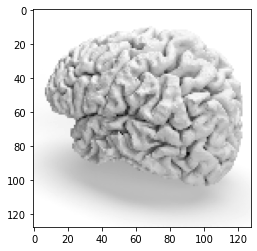

In [113]:
n = 128
x, y, extents = getMeshPoints(n)
# load the image
img = getImage("brain_both.png",n)

# and display
plt.imshow(img,cmap='gray')
np.size(img,1)

Alright. Let's get right to it. What does the Fourier transform of this image look like? We will plot the magnitude spectrum which shows the amplitude of each of the sinusoidal gratings that make up an image.

In [ ]:
# take Fourier transform
imgFFT = np.fft.fft2(img)

# now we will shift the image so that the middle will
# be the DC (luminance) component (otherwise, it plots
# in a way that is not as intuitive to understand)
imgFFT = np.fft.fftshift(imgFFT)

def displayMagSpectrum(imgFFT):
  # get center line
  centerLine = int(np.round(np.size(imgFFT,1)/2))

  # Display the amplitude spectrum by taking the magnitude
  # of the fourier transform (note that due to technical reasons
  # in how the FFT is computed - with complex exponentials - the
  # values of the FFT are complex numbers where the magnitude 
  # relfects the weight of the sinusoidal component and the phase
  # of the number represents the phase of the sinusoidal component
  # needed)
  imgMag = np.abs(imgFFT)

  # The image spectrum is typicall really hard to see when
  # plotted directly because the DC value is really large
  # compared to other values, and so the scaling in imshow
  # makes it look like one big black square with a bright
  # point at the very center. To make it easier to see,
  # we normalize the values between 0 and 1 and then
  # we are going to pump it through a function that boosts
  # up small values to make the image more visible. Not
  # really important what this function is, but for your 
  # reference, I'm using 1 - exponential function
  imgMagNormalized = (imgMag - imgMag.min())/(imgMag.max()-imgMag.min())
  imgMagAdjusted = (1-np.exp(-imgMagNormalized**0.1))/(1-np.exp(-1))

  # display
  plt.subplot(1,3,1)
  plt.imshow(imgMagAdjusted,cmap='gray',extent=extents)
  plt.subplot(1,3,2)
  plt.plot(imgMag[:,centerLine])
  plt.xlabel('Frequency component')
  plt.ylabel('Magnitude')
  plt.subplot(1,3,3)
  plt.plot(imgMag[centerLine,:])


32


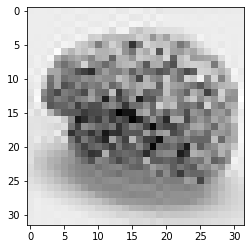

In [ ]:
# down sample function
def downSample(img):
  # get size
  n = np.size(img,1)
 
  # take Fourier transform and shift components so that dc is in the center
  imgFFT = np.fft.fftshift(np.fft.fft2(img))

  # now get where the dc component is
  dc = n/2
 
  # and keep only half the frequencies around
  # that component. Note that means that we take
  # n/4 becase there are n/2 frequencies in the 
  # image (the other n/2 are the "negative" frequencies)
  halfComponents = n/4

  negBound = int(np.floor(dc-halfComponents))
  posBound = int(np.ceil(dc+halfComponents))
  imgDownSampledFFT = imgFFT[negBound:posBound,negBound:posBound]

  # take the inverse transform (and just get the real part)
  imgDownSampled = np.real(np.fft.ifft2(np.fft.fftshift(imgDownSampledFFT)))

  # and return
  return(imgDownSampled)

imgDownSampled = downSample(img)
plt.imshow(imgDownSampled,cmap='gray')
print(np.size(imgDownSampled,1))


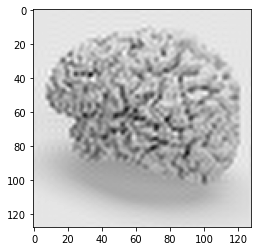

In [ ]:
# down sample function
def upSample(img):

  # get size
  n = np.size(img,1)
 
  # take Fourier transform and shift components so that dc is in the center
  imgFFT = np.fft.fftshift(np.fft.fft2(img))

  # create an array of zeros that is twice as large as the original
  # make sure that the type is complex to hold the complex spectrum values
  imgUpSampledFFT = np.zeros((n*2,n*2),dtype='complex')

  # and set the center frequencies of this larger image
  # to be imgFFT. What we are doing here is known as "zero padding"
  # as we are putting zeros into the higher spatial frequencies
  # This will make an image that is twice as big as the original
  # when we inverse transform back. Which means that it is interpolating
  # the original image. What function is it interpolating with? Well
  # if you think in the frequency domain, the effect of the zeros is
  # that you are essentially multiplying the transform by a square function
  # with ones in the middle and zeros on the outside. In the image
  # domain this is a sinc function, which is convolved with the image.
  dc = n
  halfComponents = n/2
  negBound = int(np.round(dc-halfComponents))
  posBound = int(np.round(dc+halfComponents))
  imgUpSampledFFT[negBound:posBound,negBound:posBound] = imgFFT

  # take the inverse transform (and just get the real part)
  imgUpSampled = np.real(np.fft.ifft2(np.fft.fftshift(imgUpSampledFFT)))

  # and return
  return(imgUpSampled)

imgUpSampled = upSample(img)
plt.imshow(imgUpSampled,cmap='gray');


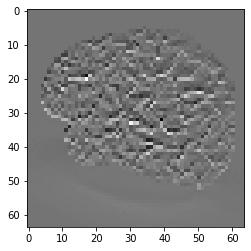

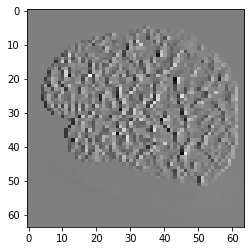

In [ ]:
# take a directional derivative of an image

# get size
n = np.size(img,1)
imgDeriv = img[1:,:]-img[0:-1,:]
imgDeriv = np.insert(imgDeriv,0,0,axis=0)
plt.imshow(imgDeriv,cmap='gray')
plt.figure()
imgDeriv = img[:,1:]-img[:,0:-1]
imgDeriv = np.insert(imgDeriv,0,0,axis=1)
plt.imshow(imgDeriv,cmap='gray')


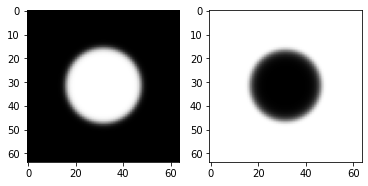

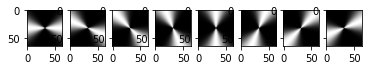

In [ ]:
x = np.linspace(0,1,100)
def logistic(x,centerX,slope):
  y = 1 / (1 + np.exp(-slope*(x-centerX)))
  return(y)

lowPass = 1-logistic(x,0.5,50)
hiPass = np.sqrt(1-lowPass**2)
plt.plot(x,lowPass);
plt.plot(x,hiPass);

def makePyramidFilters(n,k):
  # create a mesh of x, y points
  x,y,extents = getMeshPoints(n);
  # convert into radial coordinates
  r = np.sqrt(x**2+y**2)
  theta = np.arctan2(y,x)
  
  # use a sigmoidal function for the low pass filter
  # note that this is not identical to what is 
  # in the Simoncelli & Freeman paper, as they
  # only specify what the characteristics of the
  # filters should be like (that they should strictly
  # block out frequencies above the cutoff, they
  # should sum-of-squares to 1 and be recursive,
  # but they don't actually derive a form for the
  # filters - just say that they can approximate
  # with a least-squares approximation. So,
  # here we are using a logistic function with
  # a very steep slope. 
  lowPassFilter = 1-logistic(r,0.5,50)
  hiPassFilter = np.sqrt(1-lowPassFilter**2)
  
  # ok, now make the orientation filters
  orientationFilters = []
  for iFilter in range(0,k):
    # set orientation preference
    orientationPreference = iFilter*np.pi/k
    # the orientation filter is just the a sinusoidal function raised to a power of k-1
    orientationFilters.append(np.abs(np.cos(theta-orientationPreference)**(k-1)))

  # return the filters
  return lowPassFilter, hiPassFilter, orientationFilters

k = 8
n = 64
lowPassFilter, hiPassFilter, orientationFilters = makePyramidFilters(n,k)

plt.subplot(1,2,1)
plt.imshow(lowPassFilter,cmap='gray')
plt.subplot(1,2,2)
plt.imshow(hiPassFilter,cmap='gray')
plt.figure()
for iFig in range(0,k):
  plt.subplot(1,k,iFig+1)
  plt.imshow(orientationFilters[iFig],cmap='gray')

#yowsa = np.sqrt(orientationFilters[0]**2 + orientationFilters[1]**2 + orientationFilters[2]**2);
#print(np.max(yowsa))
#print(np.min(yowsa))

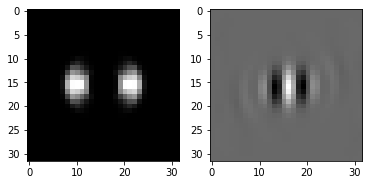

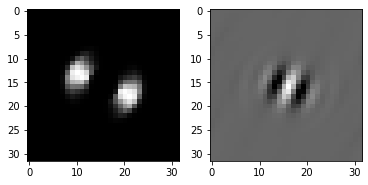

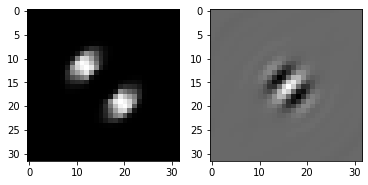

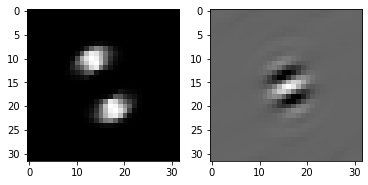

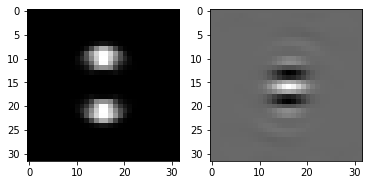

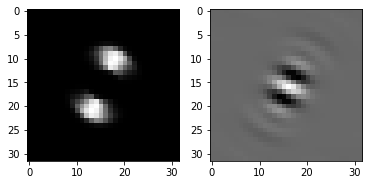

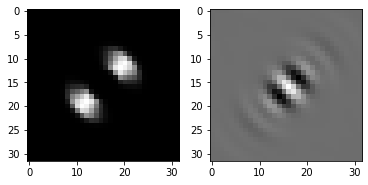

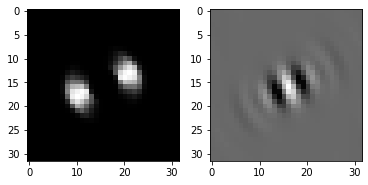

In [ ]:
k = 8
n = 32
lowPassFilter, hiPassFilter, orientationFilters = makePyramidFilters(n,k)
lowPassFilter2, hiPassFilter2, orientationFilters2 = makePyramidFilters(int(n/2),k)

bandPassFilter = upSample(downSample(lowPassFilter))
filter = bandPassFilter
bandPassFilter = lowPassFilter

negBound = int(np.floor(n/2-n/4))
posBound = int(np.ceil(n/2+n/4))
bandPassFilter[negBound:posBound,negBound:posBound] = bandPassFilter[negBound:posBound,negBound:posBound]*hiPassFilter2

# make an image filter out of one of the above

for iFilter in range(0,k):
  filter = bandPassFilter * orientationFilters[iFilter]
  plt.figure()
  plt.subplot(1,2,1)
  plt.imshow(filter,cmap='gray')

  convFilter = np.real(np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(filter))))

  plt.subplot(1,2,2)
  plt.imshow(convFilter,cmap='gray')


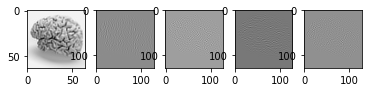

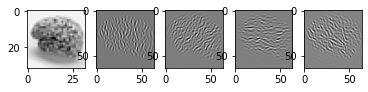

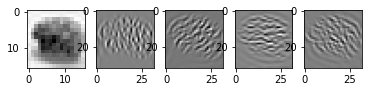

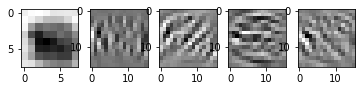

In [ ]:

# get pyramid output for one layer of the pyramid
def pyramidEncode(img,k):
  # get size of image
  n = np.size(img,1)
  
  # get the filters
  lowPassFilter, hiPassFilter, orientationFilters = makePyramidFilters(n,k)

  # split into a low pass and a high pass filter
  # first take transform of image
  imgFFT = np.fft.fftshift(np.fft.fft2(img))
  
  # apply the low pass and high pass filters
  hiPassFilteredImgFFT = imgFFT * hiPassFilter
  lowPassFilteredImgFFT = imgFFT * lowPassFilter
  
  # apply the orientation filters to the hi pass image and take the inverse transform
  orientationAndHiPassFilteredImg = []
  for iFilter in range(0,k):
    # filter
    orientationAndHiPassFilteredImgFFT = hiPassFilteredImgFFT * orientationFilters[iFilter]
    #orientationAndHiPassFilteredImgFFT = hiPassFilteredImgFFT
    # and take the inverse transfrom
    orientationAndHiPassFilteredImg.append(np.real(np.fft.ifft2(np.fft.fftshift(orientationAndHiPassFilteredImgFFT))))
  
  # now downsample and take the inverse transform of the low pass image
  lowPassFilteredImg = np.real(np.fft.ifft2(np.fft.fftshift(lowPassFilteredImgFFT)))
  lowPassFilteredImg = downSample(lowPassFilteredImg)

  # return
  return lowPassFilteredImg, orientationAndHiPassFilteredImg

# try with a disck image
n = 64
diskImage = np.zeros((n,n))  
x,y,extents = getMeshPoints(n)
r = np.sqrt(x**2+y**2)
diskImage[r<0.5] = 1

k = 4
l = 4

mysave('original.png',img)
def mysave(saveName,img):
  saveImage = (img-np.min(img))/(np.max(img)-np.min(img))
  saveImage = np.repeat(saveImage[:, :, np.newaxis], 3, axis=2)
  image.imsave(saveName,saveImage)

currentImg = img;
for iLevel in range(0,l):
  # filter with the current layer and
  # use the low Pass image as the next level
  currentImg, orientationAndHiPassFilteredImg = pyramidEncode(currentImg,k)

  plt.figure()
  plt.subplot(1,k+1,1)
  plt.imshow(currentImg,cmap='gray')
  mysave("Level%02iLow.png"%(iLevel),currentImg)
  for iPlot in range(0,k):
    plt.subplot(1,k+1,iPlot+2)
    plt.imshow(orientationAndHiPassFilteredImg[iPlot],cmap='gray')
    mysave("Level%02iOrientation%02i.png"%(iLevel,iPlot),orientationAndHiPassFilteredImg[iPlot])
  


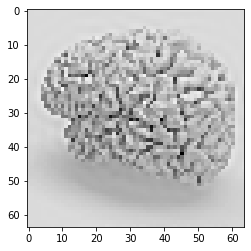

In [ ]:
# take pyramid output for one layer and reconstruct an image
def pyramidDecode(lowPassFilteredImg, orientationAndHiPassFilteredImg):
  # up sample the low Pass Filtered Image
  img = upSample(lowPassFilteredImg)

  # and the high pass orientation filtered images
  k = len(orientationAndHiPassFilteredImg)
  for iFilter in range(0,k):
    img = img + orientationAndHiPassFilteredImg[iFilter]

  return img

k = 4
lowPassFilteredImg, orientationAndHiPassFilteredImg = pyramidEncode(img,k)
reconstructedImg = pyramidDecode(lowPassFilteredImg,orientationAndHiPassFilteredImg)
plt.imshow(reconstructedImg,cmap='gray')


In [ ]:
t

Ok. So how do we interpret this Fourier spectrum? Remember that it has been shifted so the center is the mean luminance (DC offset). IT's best to think of it in radial coordinates where spatial frequency increases as you go out towards the edges and orientation as you go around in a circle around the circle.

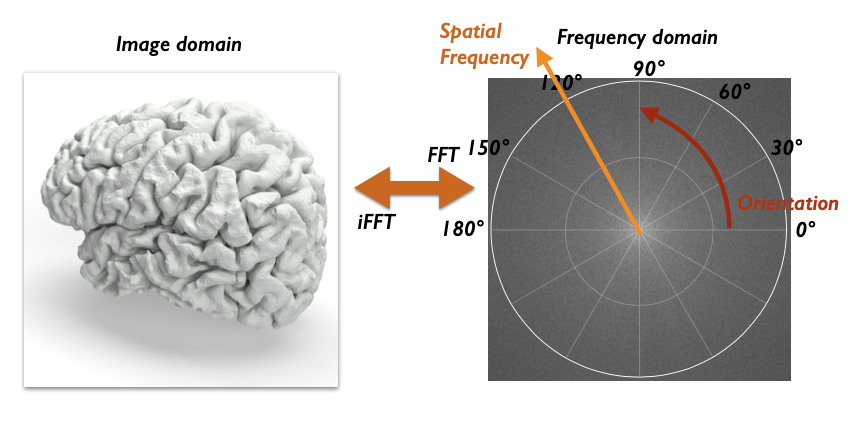


So, let's see if can confirm that. To do that, we could make a Fourier spectrum with amplitude of 1 at one point and then inverse FFT that to make sure it produces a grating with the orientation and spatial frequency that we expect. This is the picture you should have of what we are doing:

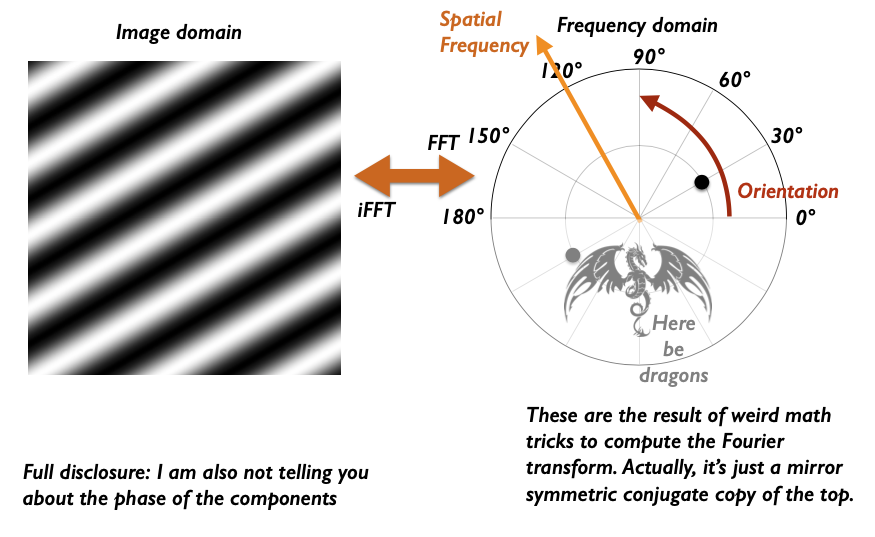

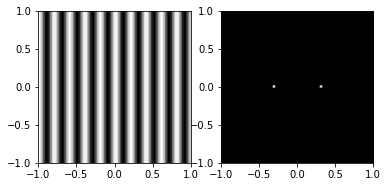

In [ ]:
# size of Fourier Tranform we are making (use an odd number so that the DC is in the center)
fftSize = 65
fftCenter = int((fftSize-1)/2)

# initalize this with all zeros
fftTest = np.zeros([fftSize,fftSize])

# let's put a one in orientation 0 and at a low spatial frequency near the center
# we'll set the location that we want to set by the coordinates xi and yi
xi = 10
yi = 0

# So, set the value to one
fftTest[fftCenter + xi,fftCenter + yi] = 1

# now, we also have to set the one in the bottom half
# of the spectrum - remember that this part is due to
# the crazy way that the FFT is computed, so, don't
# worry about this for now - just know that the FFT
# needs to be mirror-symmetric, so that's what we 
# are doing her
fftTest[fftCenter - xi,fftCenter - yi] = 1

# let's display this fourier spectrum - should be two points (note that
# we are flipping and transposing the image just because of the way that imshow
# displays a matrix)
plt.subplot(122)
plt.imshow(np.flipud(fftTest.T),cmap='gray',extent=extents)

# inverse transform
ifftTest = np.fft.ifft2(np.fft.ifftshift(fftTest))
ifftTest = np.real(ifftTest)

# show
plt.subplot(121)
plt.imshow(np.flipud(ifftTest.T),cmap='gray',extent=extents)

Now, your turn - change the xi and yi coordinates above to make an oblique grating. Or one that has a lower spatial frequency.

Make sense, so now go back and look at the Fourier spectrum that you computed for the image. Each little spot in there shows you the magnitude of the grating of a particular spatial frequency and orientation required to add together to make the image.

Ok. Now let's see if we can filter the FFT spectrum of our image and get a low-pass image of it.

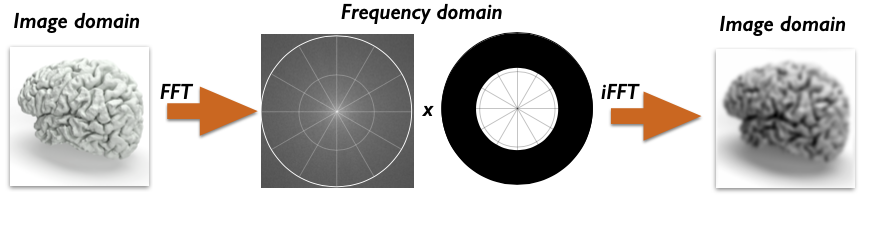

To do the filtering we need to only pass the low spatial frequencies at the center of the image and block frequencies at the edges of the image. We can do that by multiplying one of our gaussian functions with the image (which has the highest values in the center which go towards 0 towards the edge of the image). Then inverse FFT the image and see what we get.

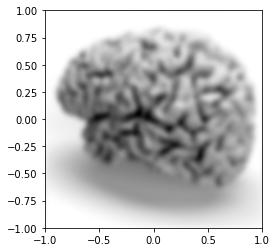

In [ ]:
# make the gaussian image
gauss = makeGaussian(x,y,0.05)

# multiply with the FFT of the image from above
filteredFFT = imgFFT * gauss

# now we inverse fft to get the image back
# remember we haft to use ifftshift to 
# shift the center component back to where
# it expected to be for the fft
filteredFFT = np.fft.ifftshift(filteredFFT)
filteredImg = np.fft.ifft2(filteredFFT)

# take the real component (this has to do with the
# way the FFT is computed with complex exponentials
# the values will all be real with no imaginary
# component, but we still need to convert from complex
# numbers back to real numbers for imshow to work)
filteredImg = np.real(filteredImg)

# and display
plt.imshow(filteredImg,cmap='gray',extent=extents)

Now your turn. Try to make a high-pass filter which only allows high spatial frequencies to pass and blocks low frequencies. Hint: what happens to the gaussian function if you do 1 - gauss? Here is the picture you should have of what we are trying to do:

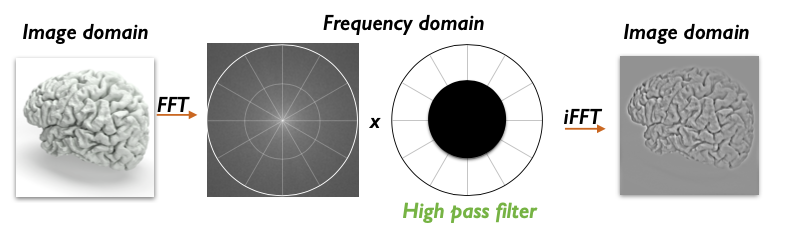

Alright. So now we can make low pass and high pass filters. What about the "oriented band-pass filter". Well, we could think about it in the image domain. If we convolve with the an oriented gabor filter, then we should get what we want. Let's try to do that using the convolution theorem. We will make the filter in the image domain, fourier transform and then multiply by the fourier transform of the image (remember the convolution theorem says this is the same as convolution). Then inverse transform back to the image domain and that should work. Right? Here is the picture of what we are trying to do:

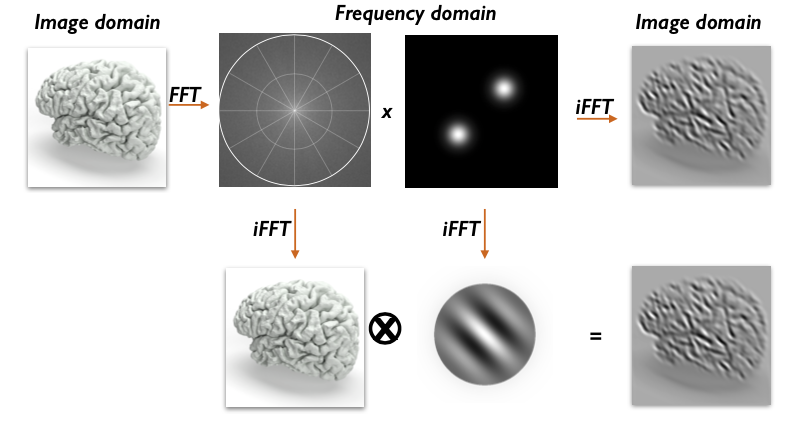

In [ ]:
# Make an oriented gabor filter
gabor = makeGaussian(x,y,0.02) * makeGrating(x,y,-45,48)

# take the fourier transform
gaborFFT = np.fft.fft2(gabor)

# get the fourier transform of the img
imgFFT = np.fft.fft2(img)

# multiply together
filteredImgFFT = gaborFFT * imgFFT

# inverse transform
filteredImg = np.fft.ifft2(filteredImgFFT)

# shift everything back
filteredImg = np.fft.ifftshift(filteredImg)

# take the real component
filteredImg = np.real(filteredImg)

# and display
plt.imshow(filteredImg,cmap='gray',extent=extents)

NameError: name 'makeGaussian' is not defined

In the Enroth-Cugell & Robson paper, they write a mathematical proof showing that if the receptive field is described by a difference of gaussian model, then the contrast-sensitivity function is also described by a difference of gaussian models. See for yourself whether this is true. Generate a difference of gaussian receptive fields where the center has a smaller standard deviation than the surround. Take the fourier transform of the receptive field and see what it looks like. 

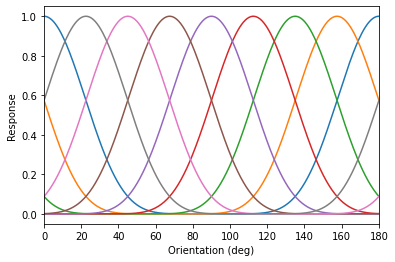

In [106]:
k = 8
x = np.linspace(0,np.pi*2,720)
offset = 0
for iFun in range(0,k):
  plt.plot(x*180/np.pi,np.abs(np.cos(x+offset+iFun*np.pi/k)**(k-1)))

#plt.plot(x*180/np.pi,np.abs(np.cos(x+offset+np.pi/4)**(k-1)))
plt.xlabel('Orientation (deg)')
plt.ylabel('Response')
plt.xlim(0,180)
plt.savefig('8basis.pdf')

[0.70710678 0.70710678]


(0.0, 360.0)

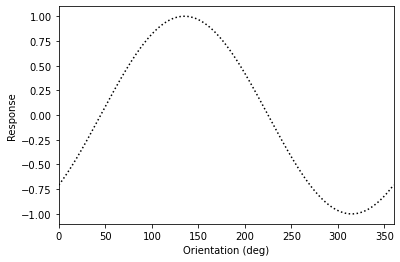

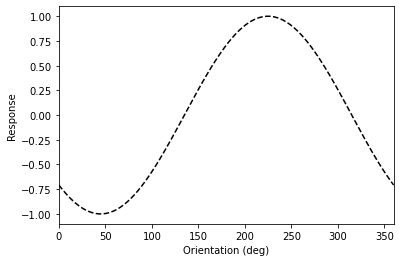

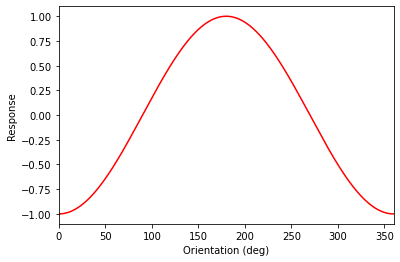

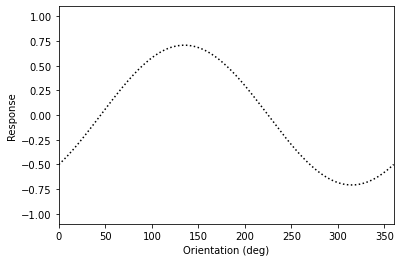

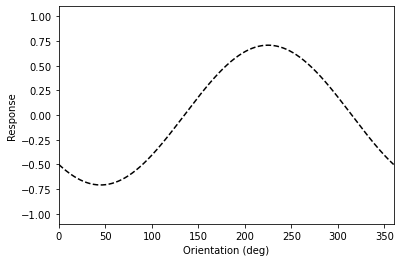

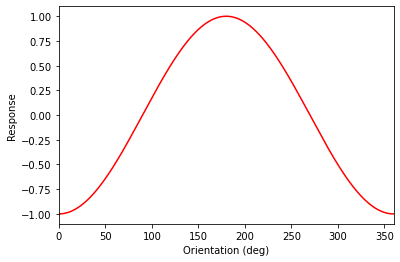

In [ ]:
k = 2
x = np.linspace(0,np.pi*2,720)
offset = (np.pi/8)+5*np.pi/8
basis1 = np.cos(x+offset+np.pi/2)**(k-1)
basis2 = np.cos(x+offset)**(k-1)

#desired phase
phase = np.pi
desired = np.cos(x+phase)**(k-1)
basis = np.vstack((basis1,basis2)).T

fitVals = np.dot((np.dot(np.linalg.inv(np.dot(basis.T,basis)),basis.T)),desired)
print(fitVals)

plt.figure()
plt.plot(x*180/np.pi,basis1,color='k',linestyle=':')
plt.xlabel('Orientation (deg)')
plt.ylabel('Response')
plt.xlim(0,360)
plt.savefig('sin1.pdf')

plt.figure()
plt.plot(x*180/np.pi,basis2,color='k',linestyle='--')
plt.xlabel('Orientation (deg)')
plt.ylabel('Response')
plt.xlim(0,360)
plt.savefig('sin2.pdf')

plt.figure()
plt.plot(x*180/np.pi,desired,color='r',linestyle='-')
plt.xlabel('Orientation (deg)')
plt.ylabel('Response')
plt.xlim(0,360)
plt.savefig('sin2.pdf')


plt.figure()
plt.plot(x*180/np.pi,basis1*fitVals[0],color='k',linestyle=':')
plt.xlabel('Orientation (deg)')
plt.ylabel('Response')
plt.xlim(0,360)
plt.ylim(-1.1,1.1)
plt.savefig('sin4.pdf')

plt.figure()
plt.plot(x*180/np.pi,basis2*fitVals[1],color='k',linestyle='--')
plt.xlabel('Orientation (deg)')
plt.ylabel('Response')
plt.xlim(0,360)
plt.ylim(-1.1,1.1)
plt.savefig('sin5.pdf')

plt.figure()
plt.plot(x*180/np.pi,basis1*fitVals[0]+basis2*fitVals[1],color='r',linestyle='-')
plt.xlabel('Orientation (deg)')
plt.ylabel('Response')
plt.xlim(0,360)
plt.savefig('sin6.pdf')


plt.xlabel('Orientation (deg)')
plt.ylabel('Response')
plt.xlim(0,360)


[-0.32762991  0.58845562  0.73917429]


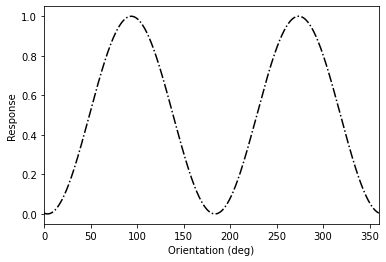

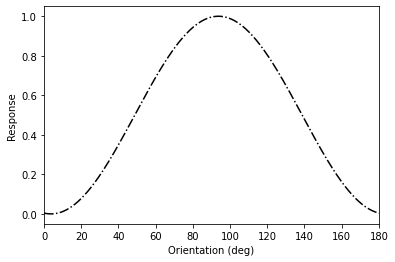

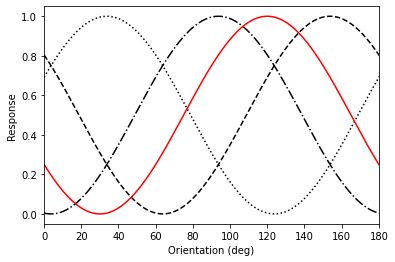

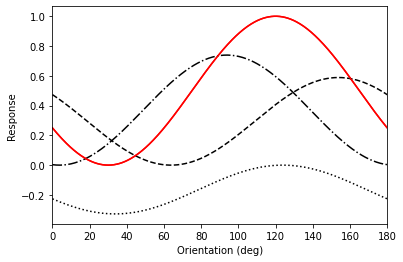

In [102]:
k = 3
x = np.linspace(0,np.pi*2,720)
offset = (np.pi/8)+5*np.pi/8+ np.pi/16
basis1 = np.cos(x+offset)**(k-1)
basis2 = np.cos(x+offset+np.pi/3)**(k-1)
basis3 = np.cos(x+offset+2*np.pi/3)**(k-1)

#desired phase
phase = np.pi/3
desired = np.cos(x+phase)**(k-1)
basis = np.vstack((basis1,basis2,basis3)).T

fitVals = np.dot((np.dot(np.linalg.inv(np.dot(basis.T,basis)),basis.T)),desired)
print(fitVals)

plt.figure()
plt.plot(x*180/np.pi,basis3,color='k',linestyle='-.')
plt.xlabel('Orientation (deg)')
plt.ylabel('Response')
plt.xlim(0,360)
plt.savefig('sin1.pdf')


plt.figure()
plt.plot(x*180/np.pi,basis3,color='k',linestyle='-.')
plt.xlabel('Orientation (deg)')
plt.ylabel('Response')
plt.xlim(0,180)

plt.savefig('sin2.pdf')


plt.figure()
plt.plot(x*180/np.pi,basis1,color='k',linestyle=':')
plt.plot(x*180/np.pi,basis2,color='k',linestyle='--')
plt.plot(x*180/np.pi,basis3,color='k',linestyle='-.')
plt.plot(x*180/np.pi,desired,color='r',linestyle='-')
plt.xlabel('Orientation (deg)')
plt.ylabel('Response')
plt.xlim(0,360)
plt.xlim(0,180)

plt.savefig('sin4.pdf')


plt.figure()
plt.plot(x*180/np.pi,desired,color='r',linestyle='-')
plt.plot(x*180/np.pi,basis1*fitVals[0],color='k',linestyle=':')
plt.plot(x*180/np.pi,basis2*fitVals[1],color='k',linestyle='--')
plt.plot(x*180/np.pi,basis3*fitVals[2],color='k',linestyle='-.')
plt.plot(x*180/np.pi,basis1*fitVals[0]+basis2*fitVals[1]+basis3*fitVals[2],color='r',linestyle='-')
plt.xlabel('Orientation (deg)')
plt.ylabel('Response')
plt.xlim(0,180)
#plt.ylim(-1.1,1.1)
plt.savefig('sin5.pdf')


Text(0, 0.5, 'N pixels')

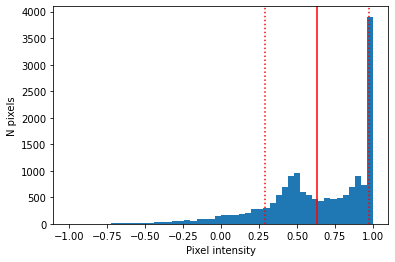

In [134]:

pixelVals = img.flatten()
meanPixel = np.mean(pixelVals)
stdPixel = np.std(pixelVals)
plt.hist(pixelVals,50);
plt.axvline(np.mean(pixelVals),color='r')
plt.axvline(np.mean(pixelVals)-stdPixel,color='r',linestyle=':')
plt.axvline(np.mean(pixelVals)+stdPixel,color='r',linestyle=':')
plt.xlabel('Pixel intensity')
plt.ylabel('N pixels')

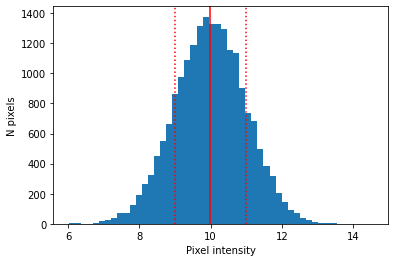

In [151]:

#pixelVals = np.random.normal(loc=10,scale=1,size=20000)**4
pixelVals = np.random.normal(loc=10,scale=1,size=20000)
meanPixel = np.mean(pixelVals)
stdPixel = np.std(pixelVals)
plt.hist(pixelVals,50);
plt.axvline(np.mean(pixelVals),color='r')
plt.axvline(np.mean(pixelVals)-stdPixel,color='r',linestyle=':')
plt.axvline(np.mean(pixelVals)+stdPixel,color='r',linestyle=':')

plt.xlabel('Pixel intensity')
plt.ylabel('N pixels')
plt.savefig('pixelstats.pdf')